# Imports and Reading Data

In [20]:
import pandas as pd
import numpy as np
import scipy as sp

import nltk
import re

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading all the requirements
# !pip install scikit-multilearn
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

# !pip install contractions
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_union

from tqdm import tqdm

# !pip install -U imbalanced-learn

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Setting global parameters for the Plots
rcParams['figure.figsize'] = 18, 9 
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

In [2]:
# Read the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

labels = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']

# Preprocessing

### Basic text preprocessing





1.   Remove URLs, HTML Tags, Non-Alphanumeric characters, extra whitespaces, lowercase
2.   Lemmatize
3.   Remove Stopwords
4.   Remove words with length <= 2
5.   Fix Contractions

In [3]:
class preprocess:

    def __init__(self):
        pass

    def clean(self, df, column):
      
        # applying all the methods in sequence
        df[column] = df[column].str.lower()
        df[column] = self.fix_contractions(df, column)

        # df[column] = df[column].apply(self.rm_decontracted)
        df[column] = df[column].apply(self.rm_urls)
        df[column] = df[column].apply(self.rm_html_tags)
        df[column] = df[column].apply(self.rm_non_alpha)
        # df[column] = self.rm_stopwords(df, column)

        # df[column] = df[column].apply(self.rm_patterns_removal) #ZZZZZZ REMOVER
        df[column] = df[column].apply(self.rm_repeated_text) ### ZZZZ TO Z
        df[column] = df[column].apply(self.rm_numword_removal)
        df[column] = self.rm_whitespace(df, column)

        # lowercasing the text


        df = self.lemmatization(df, column)
        # df[column] = self.rm_stopwords(df, column)
        # df = self.remove_less_2(df, column)
    
        return df

    def rm_urls(self, text):
        return re.sub(r'http\S+', ' ', text)
    
    def rm_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def rm_non_alpha(self, text):
        return re.sub('[^a-zA-Z]', ' ', text)

    def rm_whitespace(self, df, column):
        return df[column].apply(lambda x : " ".join(x.split()))

    def lemmatization(self, df, column):
        lemma = WordNetLemmatizer()

        # Lemmatizing with respect to the verb form and noun form
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))

        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='a') for w in x.split(" ")]))	
        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='r') for w in x.split(" ")]))	
        # df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='s') for w in x.split(" ")]))		

        return df

    def rm_stopwords(self, df, column):

        # Generating all the stop words of english and removing no,not nor as they are significantly important
        stop = stopwords.words('english')
        not_stop_words = {'no', 'not', 'nor','very','but'}
        modified_stop = [ele for ele in stop if ele not in not_stop_words]

        return df[column].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))

    # As the words with less than length 2 will not contribute to toxicity in a general manner
    def _clean_small(self, text):
        return re.sub(r'\b\w{1,2}\b', '', text)

    # After every re.sub we get varied amount of whitespaces so it is essential to remove white spaces
    def remove_less_2(self, df, column):
        df[column] = df[column].apply(self._clean_small)
        df[column] = self.rm_whitespace(df, column)
        return df

    # zzzzzzzzzz remover
    def rm_patterns_removal(self,text): 
        return re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',text)

    #function to remove words with numbers
    def rm_numword_removal(self,text):
        return re.sub("\S*\d\S*", " ", text).strip()

    def rm_decontracted(self,text):
      phrase = re.sub(r"\'t", " not", text)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      return phrase

    # zzzzzzzzzz updater to z remover
    def rm_repeated_text(self,text):
      return re.sub(r'(.)\1{2,}', r'\1', text) 

    def fix_contractions(self, df, column):
        return df[column].apply(contractions.fix)

In [4]:
df_train = preprocess().clean(df_train, 'text')
df_test = preprocess().clean(df_test, 'text')

# EDA (Exploratory Data Analysis)

### Count of comments per category

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

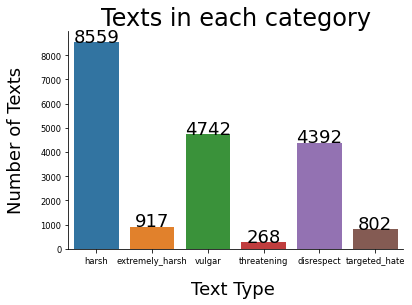

In [5]:
# List all the target columns
categories = list(df_train.columns.values)
categories.remove('id')
categories.remove('text')

#Plot
ax = sns.barplot(x=categories, y=df_train.iloc[:, 2:].sum().values)

#Labelling
plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

#For accessing the subplots in the graph
rects = ax.patches

category_values = df_train.iloc[:, 2:].sum().values

#For each subplot we need to assign a x coordinate, y coordinate and label with the orientation and fontsize
for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)

plt.show()

**Observation**: Our dataset has severe class imbalance. Most conventional classification algorithms perform badly on imbalanced datasets.

### Count of comments with multiple labels

Now let us count the number of comments having multiple labels.

In [6]:
# Finding the rows which correspond to the toxic comments by looking at the toxic column's values.
df_toxic = df_train[(df_train[['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']] > 0).any(axis=1)]
len(df_toxic)

9076

There are only 9076 "Toxic comments" out of 89,359 total comments.

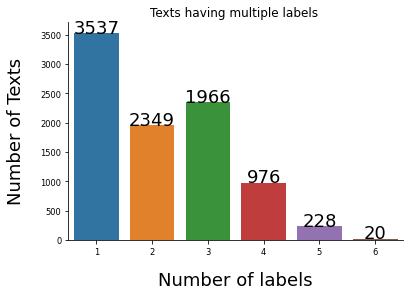

In [7]:
#Sums of the toxic columns for each row
rowSums = df_train.iloc[:, 2:].sum(axis=1)

# corresponding value counts for number of toxic labels
multiLabel_counts = rowSums.value_counts()

#Taking all the non-zero aka toxic comments counts only
multiLabel_counts = multiLabel_counts.iloc[1:]

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
category_values = multiLabel_counts.values

for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

### Top words

Now, let us find the top 100 words by frequency (for toxic comments only)

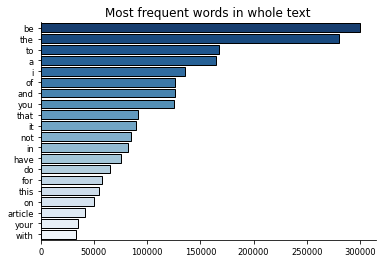

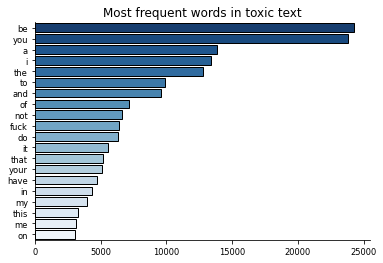

In [8]:
# value counts of each word in all the sentences.
list_words = pd.Series(' '.join(df_train.text).lower().split()).value_counts()
toxic_words = pd.Series(' '.join(df_toxic.text).lower().split()).value_counts()

sns.barplot(y=list_words.iloc[:20].index, x=list_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in whole text")
plt.show()

ax = sns.barplot(y=toxic_words.iloc[:20].index, x=toxic_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in toxic text")
plt.show()

**Observation**: "Clean" words are more frequent than "Toxic" words. This was expected because only about 10% comments are toxic.

### Wordcloud

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

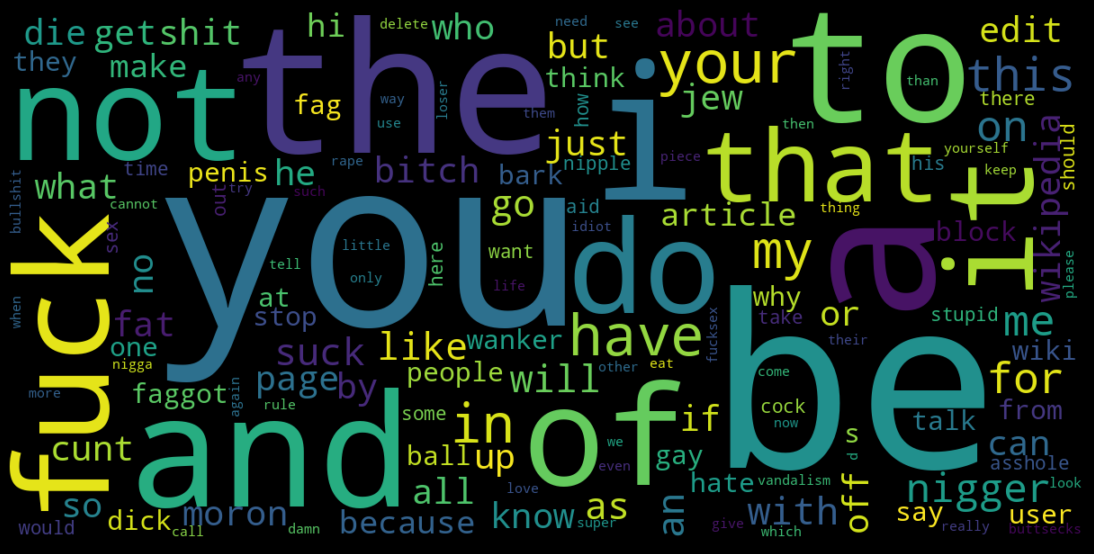

In [9]:
def generate_word_cloud(text):
    wordcloud = WordCloud(background_color = 'black', scale=3, max_words=150).generate_from_frequencies(text)

    fig = plt.figure(figsize = (15, 15), facecolor = 'black', edgecolor = 'black')
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(toxic_words)

### Length of Comments

Next, we will plot the length of comments. We can observe that most comments are less than 100 words long.

Text(0, 0.5, 'Count of Comments')

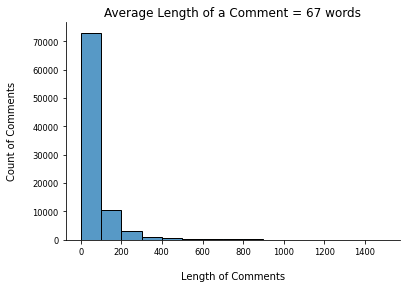

In [10]:
text_len = df_train.text.str.split().str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())) + " words")
# plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=100)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Text -> Words

In [11]:
# For training full train data

X_train = df_train['text'].to_numpy()
Y_train = df_train.drop(columns=["id", "text"]).to_numpy()
X_test = df_test['text'].to_numpy()

In [12]:
# # For testing purposes, split training data into train and test
# # Here we are using iterative_train_test_split for stratified multi-label split

# Y = df_train.drop(columns=["id", "text"]).to_numpy()
# X = df_train.iloc[:, :2].to_numpy()
# X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.1)
# X_train = X_train[:, 1]
# X_test = X_test[:, 1]
# X_test = df_test['text'].to_numpy()

### Tf-idf (words) + Tf-idf (chars)

In [13]:
vectorizer_word = TfidfVectorizer(binary=True, max_features=30000, dtype=np.float32)
vectorizer_char = TfidfVectorizer(binary=True, analyzer='char', max_features = 30000, ngram_range=(1, 4), dtype=np.float32)

vectorizer = make_union(vectorizer_word, vectorizer_char, n_jobs=-1)
vectorizer

FeatureUnion(n_jobs=-1,
             transformer_list=[('tfidfvectorizer-1',
                                TfidfVectorizer(binary=True,
                                                dtype=<class 'numpy.float32'>,
                                                max_features=30000)),
                               ('tfidfvectorizer-2',
                                TfidfVectorizer(analyzer='char', binary=True,
                                                dtype=<class 'numpy.float32'>,
                                                max_features=30000,
                                                ngram_range=(1, 4)))])

In [14]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Exporting Preprocessed data

In [26]:
np.save("./preprocessed_data/Preprocessed_Y_train", Y_train)

In [25]:

sp.sparse.save_npz("./preprocessed_data/Preprocessed_X_train", X_train)
sp.sparse.save_npz("./preprocessed_data/Preprocessed_X_test", X_test)